In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

c:\Users\30586\AppData\Local\Programs\Python\Python36\lib\site-packages\google\auth\crypt\_cryptography_rsa.py:22: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography. The next release of cryptography will remove support for Python 3.6.
  import cryptography.exceptions


Importer des données

2023-06-24 01:59:10 - 2023-07-11 10:49:42
"09 July 2023:	Measurement error with regard to fine dust values due to sudden increase in air humidity"
Nous supprimons les données contenant des informations postérieures au 9 juillet

In [2]:

data=pd.read_csv("./one_room_apartement.csv")

In [3]:
data.head()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
0,1.995,20.863,6.004,273.935,1.726,23.718,805.0,490.458,1868,518.956,...,758.0,27.774,0.923,26.690,60.385,0.04,12.983,51.839,5.402,859.499
1,1.689,20.863,6.891,296.490,1.726,23.715,806.0,490.505,1867,520.396,...,715.0,27.762,0.739,26.594,60.377,0.03,12.980,52.092,6.451,932.282
2,2.854,20.863,7.486,268.740,1.726,23.716,808.0,489.080,1857,520.139,...,742.0,27.764,3.002,26.501,60.358,0.00,12.977,51.313,6.107,851.850
3,1.635,20.862,5.874,262.821,1.726,23.719,807.0,488.189,1881,518.782,...,746.0,27.748,1.287,26.611,60.426,0.03,12.993,53.420,5.489,829.355
4,1.579,20.864,7.068,297.597,1.725,23.712,809.0,485.401,1880,516.398,...,717.0,27.760,0.527,26.681,60.435,0.03,12.990,52.284,6.723,926.864


In [4]:
data.tail()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
12441,2.493,20.842,3.159,139.359,1.578,27.999,738.0,432.277,1799,715.633,...,661.0,32.491,0.652,30.628,47.086,0.00,12.860,59.537,2.733,432.119
12442,2.550,20.843,2.592,151.838,1.577,28.029,738.0,433.938,1782,723.661,...,653.0,32.507,0.590,30.105,47.237,0.08,12.923,59.008,2.277,475.226
12443,2.020,20.840,3.614,163.927,1.575,28.074,741.0,435.733,1804,733.135,...,650.0,32.559,1.847,29.544,47.292,0.31,12.970,59.580,3.254,520.100
12444,2.970,20.841,2.830,130.268,1.573,28.110,746.0,432.326,1799,739.224,...,654.0,32.575,1.636,29.012,47.268,0.36,12.989,59.275,2.154,408.629
12445,5.349,20.840,3.612,122.472,1.573,28.149,745.0,433.729,1786,747.578,...,648.0,32.597,3.106,28.614,47.254,0.23,13.013,59.092,1.747,381.507


Les données sont de 12445x31 et nous devons filtrer les valeurs nulles et les paramètres de mesure qui ne nous concernent pas.

In [5]:
print(data)

       TypPS  oxygen   pm10   cnt0_5     co  temperature  performance  \
0      1.995  20.863  6.004  273.935  1.726       23.718        805.0   
1      1.689  20.863  6.891  296.490  1.726       23.715        806.0   
2      2.854  20.863  7.486  268.740  1.726       23.716        808.0   
3      1.635  20.862  5.874  262.821  1.726       23.719        807.0   
4      1.579  20.864  7.068  297.597  1.725       23.712        809.0   
...      ...     ...    ...      ...    ...          ...          ...   
12441  2.493  20.842  3.159  139.359  1.578       27.999        738.0   
12442  2.550  20.843  2.592  151.838  1.577       28.029        738.0   
12443  2.020  20.840  3.614  163.927  1.575       28.074        741.0   
12444  2.970  20.841  2.830  130.268  1.573       28.110        746.0   
12445  5.349  20.840  3.612  122.472  1.573       28.149        745.0   

           co2  measuretime      so2  ...  health  temperature_o2 cnt2_5  \
0      490.458         1868  518.956  ...   758

In [6]:
nan_rows_count = data.isna().any(axis=1).sum()

print(f"\n Le nombre de lignes contenant des valeurs NaN est de: {nan_rows_count}")


 Le nombre de lignes contenant des valeurs NaN est de: 0


**Nettoyage des données**

Supprimer les lignes Nan et les colonnes de caractéristiques inintéressantes

In [7]:
data.drop(['TypPS', 'cnt0_5','cnt1','performance','measuretime','temperature_o2','sound_max','cnt5','cnt10','dCO2dt','health','cnt2_5','humidity_abs','dHdt','cnt0_3'], axis=1, inplace=True)
data.dropna(inplace=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])

Nous supprimons les données contenant des informations postérieures au 9 juillet

"température", "pression", "humidité" à la fin des colonnes de données

In [8]:
dates_to_remove = ['2023-07-09','2023-07-10','2023-07-11']
dates_to_remove = pd.to_datetime(dates_to_remove)
data = data[~data['timestamp'].dt.normalize().isin(dates_to_remove)]
columns = list(data.columns)
columns.remove('temperature')
columns.remove('pressure')
columns.remove('humidity')
columns.extend(['temperature', 'pressure', 'humidity'])

data = data[columns]

Modifier le nom de timestamp et le convertir en index

In [9]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

timestamp_col = data.pop('timestamp')
data.insert(0, 'date', timestamp_col)

data = data.set_index(['date'])

print(data.tail(10))

                     oxygen    pm10     co      co2      so2     no2     pm1  \
date                                                                           
2023-07-08 23:40:25  20.771  14.125  1.626  484.797  1139.90  69.921  10.375   
2023-07-08 23:42:24  20.771  13.626  1.625  485.178  1138.44  70.182  10.686   
2023-07-08 23:44:25  20.776  16.510  1.624  488.142  1136.82  70.427  11.233   
2023-07-08 23:46:25  20.778  17.540  1.621  486.802  1134.34  70.437  11.883   
2023-07-08 23:48:26  20.778  18.675  1.619  486.528  1132.36  70.288  12.278   
2023-07-08 23:50:26  20.778  15.895  1.616  485.832  1128.76  70.419  11.941   
2023-07-08 23:52:25  20.778  17.712  1.613  486.623  1123.33  70.439  12.091   
2023-07-08 23:54:26  20.778  15.942  1.611  487.518  1118.35  70.315  11.641   
2023-07-08 23:56:28  20.778  15.670  1.609  490.148  1115.68  69.342  11.238   
2023-07-08 23:58:27  20.776  18.649  1.607  493.541  1114.81  68.738  12.237   

                      dewpt     tvoc   

Présenter l'évolution de la valeur de la mesure qui nous intéresse au cours de l'échantillon

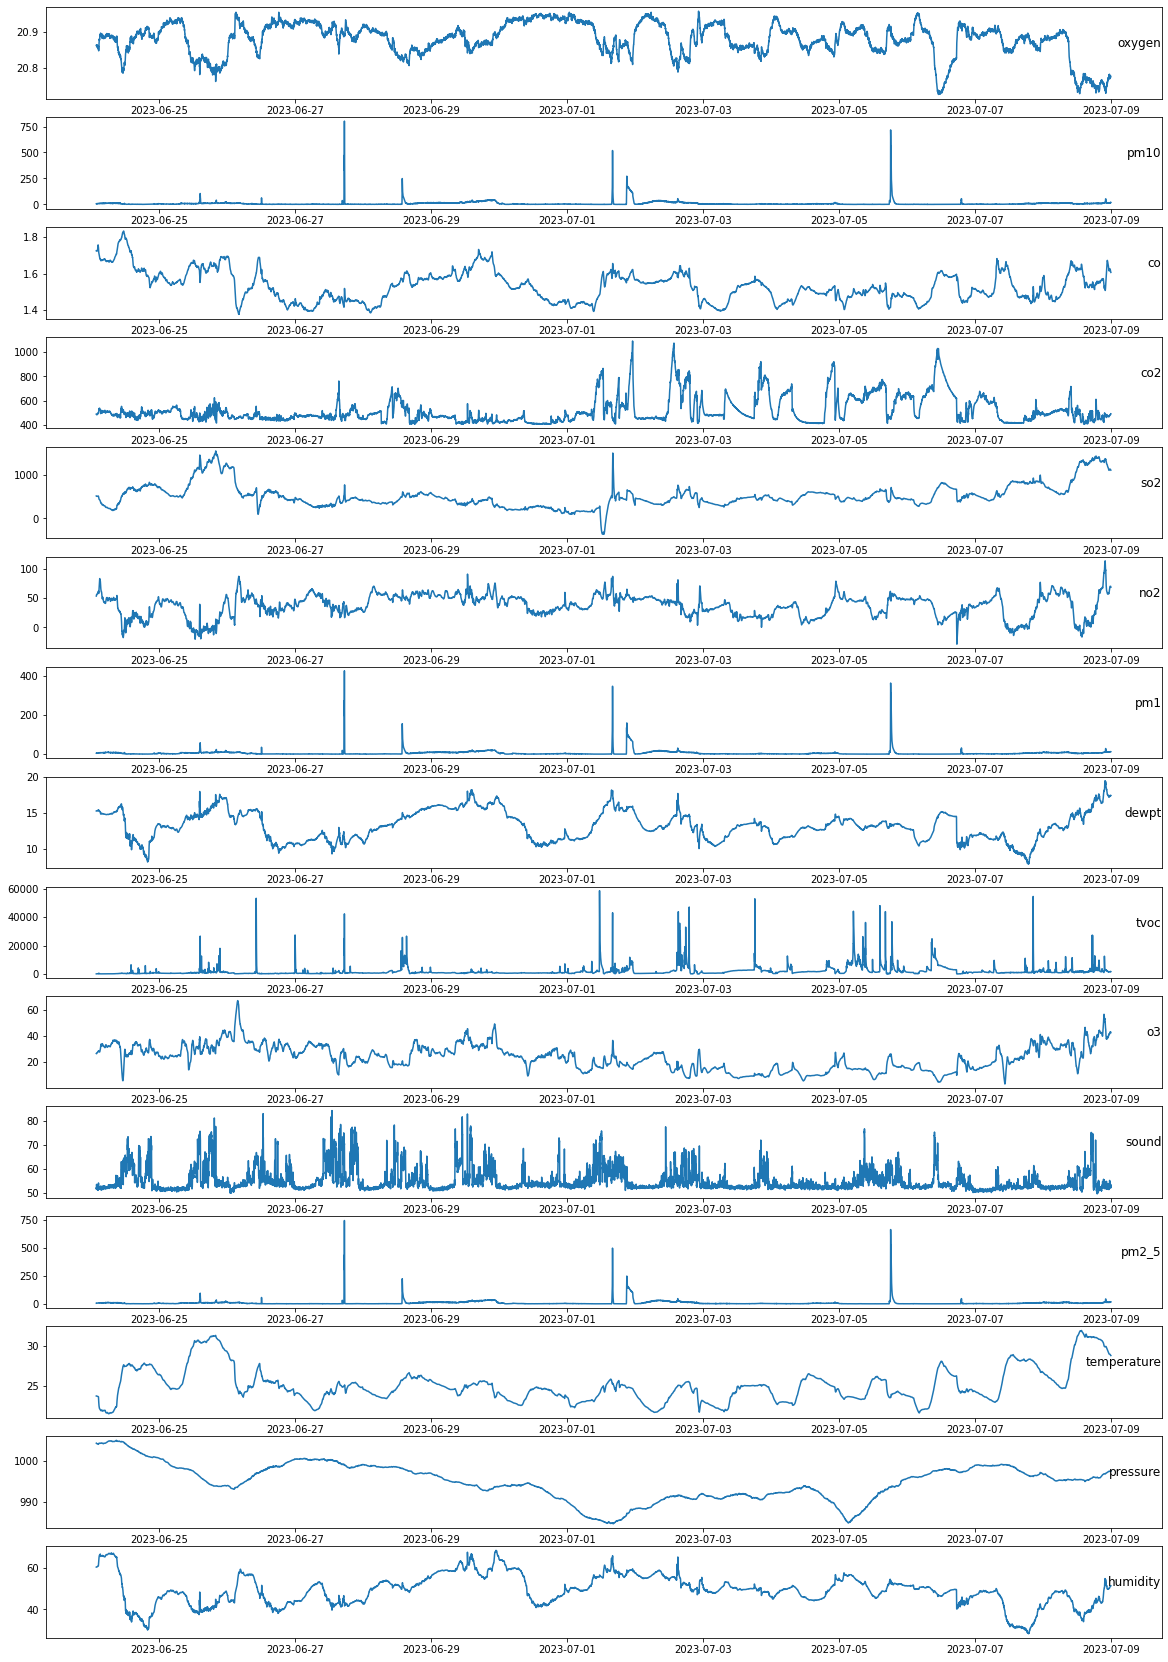

In [10]:
values = data.values
dates = data.index
groups = [0, 1, 2, 3, 4, 5, 6, 7 ,8 ,9 ,10 ,11 ,12, 13, 14]
i = 1

plt.figure(figsize=(20,30))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates,values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()#date

**Multivariate LSTM Predictive Modeling**

In [11]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


Les données de la série temporelle sont converties en données d'apprentissage supervisé et des étiquettes sont générées. Les variables d'entrée sont ensuite normalisées. Compte tenu des mesures de la pollution et des conditions météorologiques de l'heure précédente (t-1), nous posons le problème de l'apprentissage supervisé pour prédire la concentration de la pollution à l'heure actuelle (t).

In [12]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #  (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)] 
    agg = pd.concat(cols, axis=1)
    agg.columns = names


    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [13]:
values = data.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
1,0.588753,0.007486,0.763676,0.121727,0.459352,0.577556,0.011164,0.637324,0.001507,0.365211,...,0.763676,0.121795,0.460102,0.586407,0.013817,0.636977,0.001491,0.363713,0.076055,0.008636
2,0.588753,0.008592,0.763676,0.121795,0.460102,0.586407,0.013817,0.636977,0.001491,0.363713,...,0.763676,0.119705,0.459968,0.592357,0.011707,0.636631,0.001670,0.362262,0.053790,0.008175
3,0.588753,0.009334,0.763676,0.119705,0.459968,0.592357,0.011707,0.636631,0.001670,0.362262,...,0.763676,0.118399,0.459262,0.594817,0.011677,0.638362,0.001553,0.363978,0.114010,0.007348
4,0.584419,0.007324,0.763676,0.118399,0.459262,0.594817,0.011677,0.638362,0.001553,0.363978,...,0.761488,0.114310,0.458021,0.596183,0.013661,0.638016,0.001449,0.365070,0.081542,0.009000
5,0.593079,0.008813,0.761488,0.114310,0.458021,0.596183,0.013661,0.638016,0.001449,0.365070,...,0.759300,0.112774,0.457025,0.597494,0.011978,0.637930,0.001466,0.367301,0.067623,0.007897


80% train - 20% test
Ligne de départ de l'ensemble de données de test = train_x.shape[0]+1(onglet)+x(projetée)+1(test)
（2023-06-24 02:01:10<3> - 2023-07-06 00:18:22<8559>）         （2023-07-06 00:20:20<8560> - 2023-07-08 23:58:27<10698>）

In [14]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows // 1.25)
train = reframed.iloc[:train_samples, :]
test = reframed.iloc[train_samples:, :]

train_X, train_y = train.iloc[:, :-12].values, train.iloc[:, -12:].values
test_X, test_y = test.iloc[:, :-12].values, test.iloc[:, -12:].values

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8557, 1, 15) (8557, 12) (2139, 1, 15) (2139, 12)


Define the LSTM model

Il y a 50 neurones dans la première couche cachée et 11 neurones dans la couche de sortie pour prédire la concentration de pollution. La dimension des données d'entrée sera de 1 pas de temps (c'est-à-dire 2 secondes) et de 14 caractéristiques.

In [15]:
model = Sequential()
model.add(GRU(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(12))
model.compile(loss='mae', optimizer='adam')
print(model.summary())
# model = Sequential()
# model.add(LSTM(40, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(50))
# model.add(Dropout(0.2))
# model.add(Dense(11))
# model.compile(optimizer='adam', loss='mae')
# model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100)               35100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 12)                1212      
Total params: 36,312
Trainable params: 36,312
Non-trainable params: 0
_________________________________________________________________
None


Training the LSTM model

Epoch 1/400
119/119 - 1s - loss: 0.1189 - val_loss: 0.0893
Epoch 2/400
119/119 - 0s - loss: 0.0832 - val_loss: 0.0710
Epoch 3/400
119/119 - 0s - loss: 0.0660 - val_loss: 0.0576
Epoch 4/400
119/119 - 0s - loss: 0.0539 - val_loss: 0.0531
Epoch 5/400
119/119 - 0s - loss: 0.0471 - val_loss: 0.0493
Epoch 6/400
119/119 - 0s - loss: 0.0427 - val_loss: 0.0467
Epoch 7/400
119/119 - 0s - loss: 0.0395 - val_loss: 0.0430
Epoch 8/400
119/119 - 0s - loss: 0.0374 - val_loss: 0.0397
Epoch 9/400
119/119 - 0s - loss: 0.0362 - val_loss: 0.0365
Epoch 10/400
119/119 - 0s - loss: 0.0354 - val_loss: 0.0343
Epoch 11/400
119/119 - 0s - loss: 0.0355 - val_loss: 0.0379
Epoch 12/400
119/119 - 0s - loss: 0.0368 - val_loss: 0.0382
Epoch 13/400
119/119 - 0s - loss: 0.0350 - val_loss: 0.0340
Epoch 14/400
119/119 - 0s - loss: 0.0322 - val_loss: 0.0313
Epoch 15/400
119/119 - 0s - loss: 0.0303 - val_loss: 0.0309
Epoch 16/400
119/119 - 0s - loss: 0.0297 - val_loss: 0.0286
Epoch 17/400
119/119 - 0s - loss: 0.0292 - val_lo

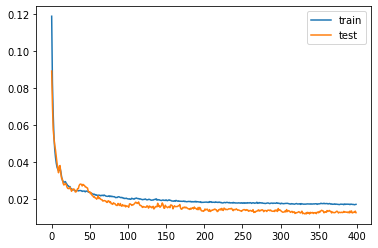

In [16]:
history = model.fit(train_X, train_y, epochs=400, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# history = model.fit(train_X, train_y, epochs=150, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Evaluating LSTM models

Les prédictions de sortie sont obtenues grâce au modèle, puis les valeurs réelles sont obtenues à partir des données d'origine.

In [17]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
selected_columns = [i for i in range(test_X.shape[1]) if i in [12, 13, 14]]
# selected_columns2 = [i for i in range(test_X.shape[1]) if i not in [3, 10, 11]]
inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:-3]
# oxygen_predict = inv_yhat[:, 0]
# pm10_predict = inv_yhat[:, 1]
# co_predict = inv_yhat[:, 2]
# co2_predict = inv_yhat[:, 3]
# so2_predict = inv_yhat[:, 4]
# no2_predict = inv_yhat[:, 5]
# pm1_predict = inv_yhat[:, 6]
# dewpt_predict = inv_yhat[:, 7]
# tvoc_predict = inv_yhat[:, 8]
# pm2_5_predict = inv_yhat[:, 9]

test_y = test_y.reshape((len(test_y), train_y.shape[1]))
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())
# oxygen_reel = inv_y[:, 0]
# pm10_reel = inv_y[:, 1]
# co_reel = inv_y[:, 2]
# co2_reel = inv_y[:, 3]
# so2_reel = inv_y[:, 4]
# no2_reel = inv_y[:, 5]
# pm1_reel = inv_y[:, 6]
# dewpt_reel = inv_y[:, 7]
# tvoc_reel = inv_y[:, 8]
# pm2_5_reel = inv_y[:, 9]

# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)


          0      1      2           3           4          5      6   \
0  20.881001  1.002  1.479  661.971008  438.337982  47.824005  0.326   
1  20.881001  0.485  1.479  651.153992  437.725983  47.506008  0.069   
2  20.879999  0.378  1.478  653.598999  435.914001  47.601002  0.252   
3  20.879999  0.836  1.478  665.013977  435.846954  47.555004  0.438   
4  20.879000  0.734  1.478  668.629028  436.254974  47.664001  0.465   

          7            8       9          10     11  
0  12.763999  1159.930054  15.432  52.966000  0.699  
1  12.744000  1146.650024  15.361  52.457001  0.118  
2  12.749000  1146.369995  15.342  52.323002  0.336  
3  12.745001  1163.060059  15.323  51.528999  0.527  
4  12.740999  1190.010010  15.343  51.537998  0.502  


Afficher valeur pic sur tvoc

Comme je veux trouver la relation entre les paramètres, je vais choisir des valeurs de pic pour découvrir la relation entre les paramètres. Mais cela semble lourd et difficile à observer, nous utilisons la méthode de la carte thermique pour y parvenir.

In [18]:
col_index = 8
col_values = inv_y_df.iloc[:, col_index]

filtered_rows = col_values[col_values > 8000]
date_indices = filtered_rows.index + train_X.shape[0] + 1
datepic = data.iloc[date_indices, col_index]
for index, value in filtered_rows.items():
    print(f"nb de ligne: {index}, valeur: {value}, dates: {datepic}\n")

nb de ligne: 247, valeur: 12475.2998046875, dates: date
2023-07-06 08:39:58    12475.30
2023-07-06 08:41:59    22527.60
2023-07-06 08:44:01    19906.70
2023-07-06 08:46:02    16101.50
2023-07-06 08:48:03    14818.90
                         ...   
2023-07-08 18:17:36    12805.50
2023-07-08 18:19:36     8968.61
2023-07-08 19:47:53     9784.25
2023-07-08 21:42:09    12539.60
2023-07-08 21:44:09     9607.30
Name: tvoc, Length: 95, dtype: float64

nb de ligne: 248, valeur: 22527.599609375, dates: date
2023-07-06 08:39:58    12475.30
2023-07-06 08:41:59    22527.60
2023-07-06 08:44:01    19906.70
2023-07-06 08:46:02    16101.50
2023-07-06 08:48:03    14818.90
                         ...   
2023-07-08 18:17:36    12805.50
2023-07-08 18:19:36     8968.61
2023-07-08 19:47:53     9784.25
2023-07-08 21:42:09    12539.60
2023-07-08 21:44:09     9607.30
Name: tvoc, Length: 95, dtype: float64

nb de ligne: 249, valeur: 19906.69921875, dates: date
2023-07-06 08:39:58    12475.30
2023-07-06 08:41:59

Comparaison des valeurs prédites et des valeurs réelles pour 12 valeurs de sortie

In [19]:
danger_limits = {
    'pm10': 101,
    'co': 201,
    'co2': 1001,
    'so2': 81,
    'no2': 81,
    'tvoc': 500,
    'o3': 100,
    'pm2_5': 61,
}

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


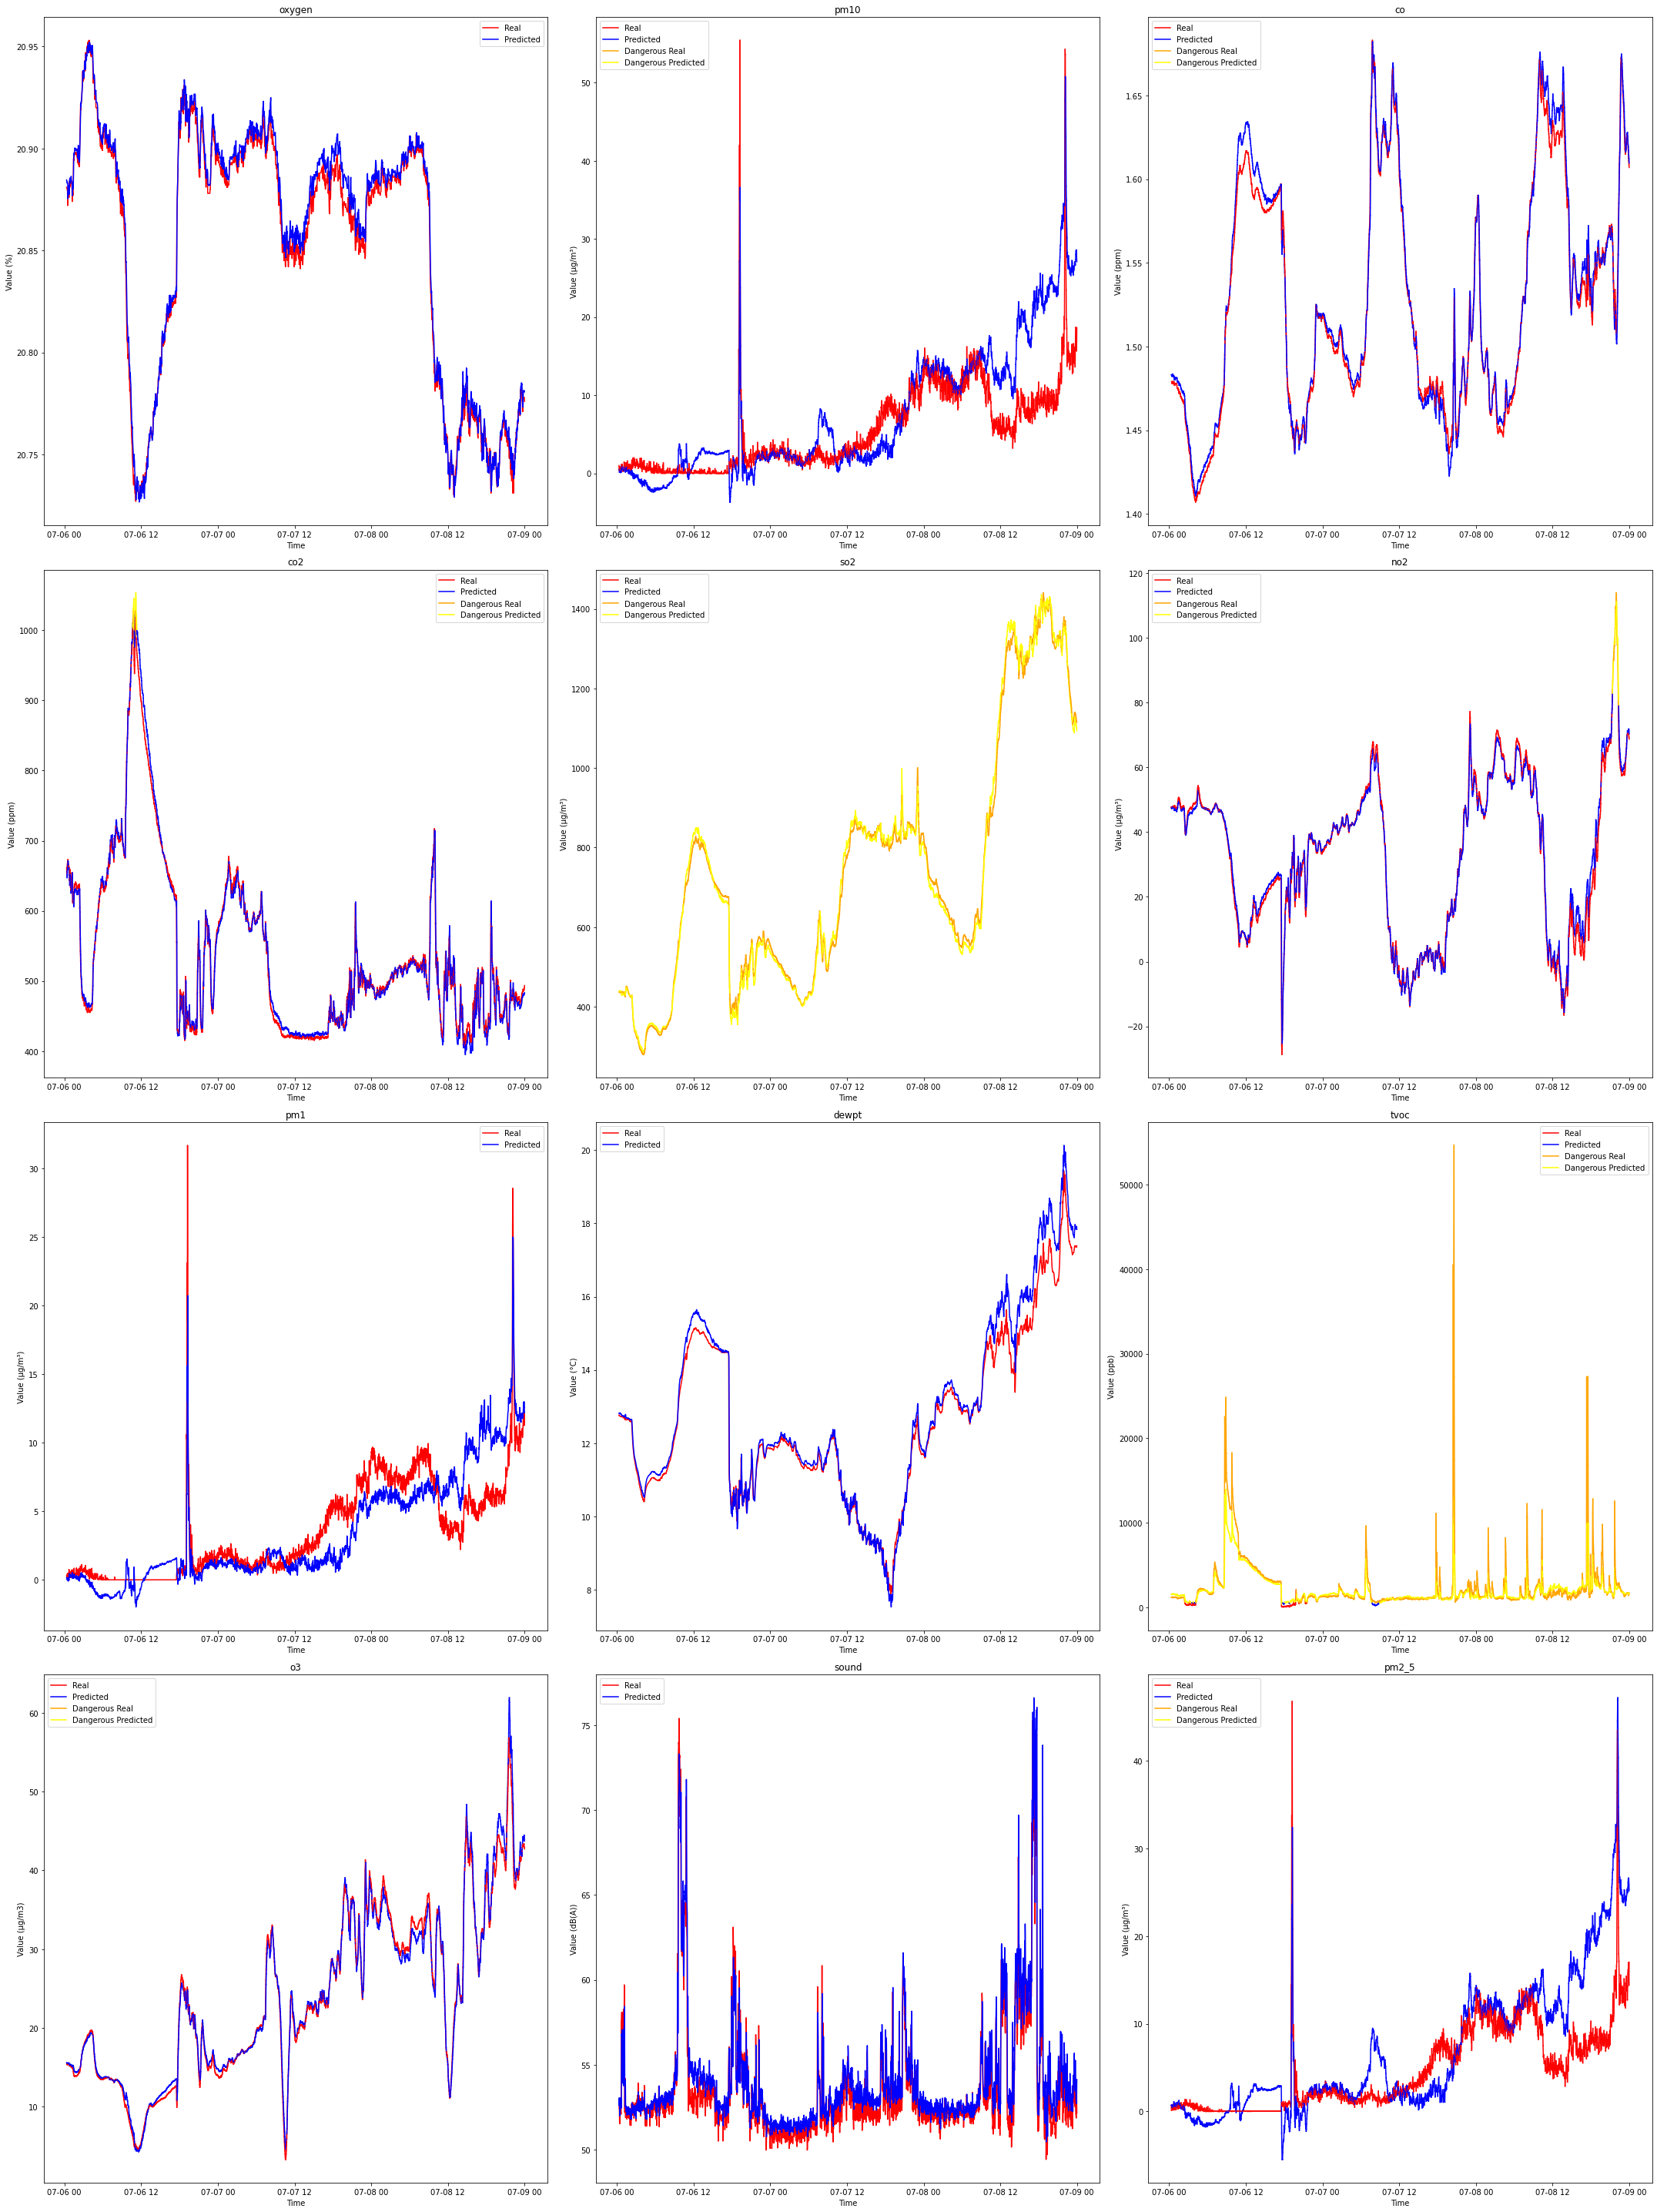

In [20]:
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'o3' : 9, 'sound': 10, 'pm2_5': 11
}

feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm', 'co2': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³', 'pm1': 'µg/m³',
    'dewpt': '°C', 'tvoc': 'ppb', 'o3': 'µg/m3', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    real_values = inv_y[:, index]
    predicted_values = inv_yhat[:, index]

    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')

    if feature in danger_limits:
        if isinstance(danger_limits[feature], tuple):
            lower, upper = danger_limits[feature]
            real_colors = ['orange' if (x < lower or x > upper) else 'red' for x in real_values]
            pred_colors = ['yellow' if (x < lower or x > upper) else 'blue' for x in predicted_values]
        else:
            limit = danger_limits[feature]
            real_colors = ['orange' if x > limit else 'red' for x in real_values]
            pred_colors = ['yellow' if x > limit else 'blue' for x in predicted_values]

        for j in range(len(dates) - 1):
            axs[row, col].plot(dates[j:j+2], real_values[j:j+2], color=real_colors[j])
            axs[row, col].plot(dates[j:j+2], predicted_values[j:j+2], color=pred_colors[j])
    else:
        axs[row, col].plot(dates, real_values, color='red', label='Real')
        axs[row, col].plot(dates, predicted_values, color='blue', label='Predicted')

    axs[row, col].legend()

for ax in axs.flat:
    handles, labels = ax.get_legend_handles_labels()
    if not labels:
        ax.plot([], [], color='red', label='Real')
        ax.plot([], [], color='blue', label='Predicted')
        ax.plot([], [], color='orange', label='Dangerous Real')
        ax.plot([], [], color='yellow', label='Dangerous Predicted')
    ax.legend()

plt.tight_layout()
plt.show()
# for i, (feature, index) in enumerate(feature_indices.items()):
#     row = i // 3
#     col = i % 3

#     axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
#     axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
#     axs[row, col].set_title(feature)
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
#     axs[row, col].legend()

# plt.tight_layout()
# plt.show()

Calcul de l'RMSE(Root Mean Square Error)

In [21]:

print(inv_y.shape, inv_yhat.shape)
selected_columns2 = [i for i in range(test_X.shape[1]) if i not in [12, 13, 14]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]
feature_names = ['oxygen', 'pm10', 'co', 'co2', 'so2', 'no2', 'pm1', 'dewpt', 'tvoc', 'o3' ,'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    # # Avoid division by zero for MAPE
    # actual_values = inv_y[:, i]
    # predicted_values = inv_yhat[:, i]
    # # Replace zeros in actual values with a small number (1e-10)
    # actual_values = np.where(actual_values == 0, 1e-10, actual_values)
    # mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    print(f'Test RMSE for {feature}: {rmse:.3f}')
    # print(f'Rest MAPE for {feature}: {mape:.3f}%')

(2139, 12) (2139, 12)
Test RMSE for oxygen: 0.006
Test RMSE for pm10: 5.451
Test RMSE for co: 0.007
Test RMSE for co2: 12.579
Test RMSE for so2: 18.791
Test RMSE for no2: 2.332
Test RMSE for pm1: 2.250
Test RMSE for dewpt: 0.423
Test RMSE for tvoc: 2075.900
Test RMSE for o3: 0.996
Test RMSE for sound: 1.579
Test RMSE for pm2_5: 5.195


In [22]:
# iaqi_condition_withouto3 = lambda x: (x[:, 6] <= 10) & (x[:, 11] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300)
# iaqi_condition = lambda x: (x[:, 6] <= 10) & (x[:, 10] <= 25) & (x[:, 1] <= 50) & (x[:, 3] < 800) & (x[:, 8] < 300) & (x[:, 9] < 18)
# inv_y_iaq = iaqi_condition_withouto3(inv_y).astype(int)
# inv_yhat_iaq = iaqi_condition_withouto3(inv_yhat).astype(int)
# inv_y_iaq2 = iaqi_condition(inv_y).astype(int)
# inv_yhat_iaq2 = iaqi_condition(inv_yhat).astype(int)

# inv_y = np.hstack((inv_y, inv_y_iaq.reshape(-1, 1)))
# inv_yhat = np.hstack((inv_yhat, inv_yhat_iaq.reshape(-1, 1)))
# inv_y2 = np.hstack((inv_y, inv_y_iaq2.reshape(-1, 1)))
# inv_yhat2 = np.hstack((inv_yhat, inv_yhat_iaq2.reshape(-1, 1)))

In [23]:
# print("inv_y:\n", inv_y)
# print("inv_yhat:\n", inv_yhat)

PM2.5 (Particulate Matter 2.5-micrometer)

PM2.5 is measured in ug / m3 (micrograms per cubic meter of air). The predefined groups are defined in the function below:

In [24]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

inv_yhat_PM25_values = inv_yhat[:, 11]
inv_y_PM25_values = inv_y[:, 11]

inv_yhat_PM25 = np.array([get_PM25_subindex(x) for x in inv_yhat_PM25_values]).astype(float)
inv_y_PM25 = np.array([get_PM25_subindex(x) for x in inv_y_PM25_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM25.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM25.reshape(-1, 1)))

PM10 (Particulate Matter 10-micrometer)

PM10 is measured in ug / m3 (micrograms per cubic meter of air). The predefined groups are defined in the function below:

In [25]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

inv_yhat_PM10_values = inv_yhat[:, 1]
inv_y_PM10_values = inv_y[:, 1]

inv_yhat_PM10 = np.array([get_PM10_subindex(x) for x in inv_yhat_PM10_values]).astype(float)
inv_y_PM10 = np.array([get_PM10_subindex(x) for x in inv_y_PM10_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM10.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM10.reshape(-1, 1)))

SO2 (Sulphur Dioxide)

SO2 is measured in ug / m3 (micrograms per cubic meter of air). The predefined groups are defined in the function below:

In [26]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

inv_yhat_SO2_values = inv_yhat[:, 4]
inv_y_SO2_values = inv_y[:, 4]

inv_yhat_SO2= np.array([get_SO2_subindex(x) for x in inv_yhat_SO2_values]).astype(float)
inv_y_SO2 = np.array([get_SO2_subindex(x) for x in inv_y_SO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_SO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_SO2.reshape(-1, 1)))

NO2 (Any Nitric x-oxide)

NO2 is measured in ppb (parts per billion). The predefined groups are defined in the function below:

In [27]:
## NO2 Sub-Index calculation
def ugm3_to_ppb(no2_ugm3):
    MW_NO2 = 46.0055  # g/mol
    standard_volume = 24.45  # L/mol
    return (no2_ugm3 * standard_volume) / MW_NO2

def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

inv_yhat_NO2_values = inv_yhat[:, 5]
inv_y_NO2_values = inv_y[:, 5]

inv_yhat_NO2= np.array([get_NO2_subindex(x) for x in ugm3_to_ppb(inv_yhat_NO2_values)]).astype(float)
inv_y_NO2 = np.array([get_NO2_subindex(x) for x in ugm3_to_ppb(inv_yhat_NO2_values)]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_NO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_NO2.reshape(-1, 1)))

CO (Carbon Monoxide)

CO is measured in mg / m3 (milligrams per cubic meter of air). The predefined groups are defined in the function below:

In [28]:
def ppm_to_mgm3(co_ppm):
    MW_CO = 28.01  # g/mol
    standard_volume = 24.45  # L/mol
    return co_ppm * MW_CO / standard_volume
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

inv_yhat_CO_values = inv_yhat[:, 2]
inv_y_CO_values = inv_y[:, 2]

inv_yhat_CO= np.array([get_CO_subindex(x) for x in ppm_to_mgm3(inv_yhat_CO_values)]).astype(float)
inv_y_CO = np.array([get_CO_subindex(x) for x in ppm_to_mgm3(inv_yhat_CO_values)]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_CO.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_CO.reshape(-1, 1)))

O3 (Ozone or Trioxygen)

O3 is measured in ug / m3 (micrograms per cubic meter of air). The predefined groups are defined in the function below:

In [29]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

inv_yhat_O3_values = inv_yhat[:, 9]
inv_y_O3_values = inv_y[:, 9]

inv_yhat_O3= np.array([get_O3_subindex(x) for x in inv_yhat_O3_values]).astype(float)
inv_y_O3 = np.array([get_O3_subindex(x) for x in inv_y_O3_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_O3.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_O3.reshape(-1, 1)))

AQI

The final AQI is the maximum Sub-Index among the available sub-indices with the condition that at least one of PM2.5 and PM10 should be available and at least three out of the seven should be available.

There is no theoretical upper value of AQI but its rare to find values over 1000.

In [30]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

PM25_SubIndex_col = 12
PM10_SubIndex_col = 13
SO2_SubIndex_col = 14
NO2_SubIndex_col = 15
CO_SubIndex_col = 16
O3_SubIndex_col = 17

inv_yhat_Checks = ((inv_yhat[:, PM25_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, PM10_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, SO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, NO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, CO_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, O3_SubIndex_col] > 0).astype(int))

inv_y_Checks = ((inv_y[:, PM25_SubIndex_col] > 0).astype(int) +
                (inv_y[:, PM10_SubIndex_col] > 0).astype(int) +
                (inv_y[:, SO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, NO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, CO_SubIndex_col] > 0).astype(int) +
                (inv_y[:, O3_SubIndex_col] > 0).astype(int))


inv_yhat_AQI_calculated = np.max(inv_yhat[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)
inv_y_AQI_calculated = np.max(inv_y[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)

inv_yhat_AQI_calculated[(inv_yhat[:, PM25_SubIndex_col] + inv_yhat[:, PM10_SubIndex_col] <= 0) | (inv_yhat_Checks < 3)] = np.NaN
inv_y_AQI_calculated[(inv_y[:, PM25_SubIndex_col] + inv_y[:, PM10_SubIndex_col] <= 0) | (inv_y_Checks < 3)] = np.NaN

inv_yhat_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_yhat_AQI_calculated])
inv_y_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_y_AQI_calculated])

inv_yhat = np.hstack((inv_yhat, inv_yhat_AQI_calculated.reshape(-1, 1), inv_yhat_Checks.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_AQI_calculated.reshape(-1, 1), inv_y_Checks.reshape(-1, 1)))

inv_yhat_df = pd.DataFrame(inv_yhat, columns=[f'col{i}' for i in range(inv_yhat.shape[1] - 2)] + ['AQI_calculated', 'Checks'])
inv_y_df = pd.DataFrame(inv_y, columns=[f'col{i}' for i in range(inv_y.shape[1] - 2)] + ['AQI_calculated', 'Checks'])

inv_yhat_df['AQI_bucket_calculated'] = inv_yhat_AQI_bucket_calculated
inv_y_df['AQI_bucket_calculated'] = inv_y_AQI_bucket_calculated

print(inv_yhat_df.head(5))
print(inv_y_df.head(5))

        col0      col1      col2        col3        col4       col5      col6  \
0  20.884602  0.451127  1.483187  655.788574  437.954956  47.678997  0.142754   
1  20.883411  0.501056  1.482960  656.779297  437.210297  47.427876  0.174268   
2  20.883839  0.150399  1.482944  647.328918  437.656830  47.228504 -0.001861   
3  20.882895  0.255375  1.482177  650.309448  436.728546  47.390793  0.052788   
4  20.883099  0.473773  1.482670  661.408630  437.494019  47.511875  0.150505   

        col7         col8       col9  ...     col11     col12     col13  \
0  12.818042  1527.949707  15.593795  ...  0.701941  1.169902  0.451127   
1  12.807490  1519.778442  15.537749  ...  0.729273  1.215454  0.501056   
2  12.797709  1492.587280  15.534356  ...  0.432216  0.720360  0.150399   
3  12.808616  1503.497192  15.518893  ...  0.528970  0.881617  0.255375   
4  12.813620  1533.468628  15.507570  ...  0.735782  1.226304  0.473773   

        col14      col15      col16      col17  AQI_calculated

In [31]:

from sklearn.metrics import accuracy_score
accuracy_normalized = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.7653108929406265


In [32]:
num_correct = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=False)
print(num_correct) 


1637


anticiper

In [33]:
n_temps = 7
n_features = 15

reframed = series_to_supervised(scaled, n_temps, 1)

In [34]:
reframed.drop(reframed.columns[[-1,-2,-3]], axis=1, inplace=True)
reframed.head(10)

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var8(t-7),var9(t-7),var10(t-7),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
7,0.588753,0.007486,0.763676,0.121727,0.459352,0.577556,0.011164,0.637324,0.001507,0.365211,...,0.757112,0.115279,0.454809,0.596099,0.012343,0.638189,0.001476,0.370624,0.079570,0.008455
8,0.588753,0.008592,0.763676,0.121795,0.460102,0.586407,0.013817,0.636977,0.001491,0.363713,...,0.759300,0.115752,0.454247,0.596541,0.014250,0.639488,0.001593,0.373339,0.056076,0.009624
9,0.588753,0.009334,0.763676,0.119705,0.459968,0.592357,0.011707,0.636631,0.001670,0.362262,...,0.761488,0.119245,0.454146,0.598910,0.012694,0.640353,0.001630,0.373994,0.078770,0.008112
10,0.584419,0.007324,0.763676,0.118399,0.459262,0.594817,0.011677,0.638362,0.001553,0.363978,...,0.761488,0.119999,0.454584,0.599891,0.013036,0.639314,0.002238,0.374384,0.068967,0.009314
11,0.593079,0.008813,0.761488,0.114310,0.458021,0.596183,0.013661,0.638016,0.001449,0.365070,...,0.768053,0.121418,0.455741,0.601804,0.012603,0.640180,0.003386,0.376053,0.074111,0.008089
12,0.593079,0.008857,0.759300,0.112774,0.457025,0.597494,0.011978,0.637930,0.001466,0.367301,...,0.772429,0.125503,0.456684,0.604957,0.012919,0.640613,0.003392,0.379095,0.056819,0.009522
13,0.593079,0.008218,0.759300,0.112717,0.455760,0.596975,0.012386,0.638016,0.001472,0.369095,...,0.776805,0.123783,0.457308,0.607487,0.012776,0.640959,0.003172,0.381638,0.062364,0.008471
14,0.588753,0.008789,0.757112,0.115279,0.454809,0.596099,0.012343,0.638189,0.001476,0.370624,...,0.781182,0.132610,0.457578,0.611405,0.015163,0.643988,0.002926,0.383354,0.045587,0.009887
15,0.593079,0.009619,0.759300,0.115752,0.454247,0.596541,0.014250,0.639488,0.001593,0.373339,...,0.783370,0.134140,0.457142,0.614481,0.014709,0.644854,0.002631,0.385710,0.059049,0.009942
16,0.593079,0.008591,0.761488,0.119245,0.454146,0.598910,0.012694,0.640353,0.001630,0.373994,...,0.792123,0.131066,0.457181,0.616324,0.015106,0.644421,0.002414,0.387675,0.071653,0.010300


In [35]:
values = reframed.values
num_rows = data.shape[0]
train_samples = int(num_rows // 1.25)

train = values[:train_samples, :]
test = values[train_samples:, :]
n_obs = n_temps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features+3:]
test_X, test_y = test[:, :n_obs], test[:, -n_features+3:]
print( train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8557, 105) (8557, 12) (2133, 105) (2133, 12)


In [36]:
train_X = train_X.reshape((train_X.shape[0], n_temps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_temps, n_features))

print(test_X.shape,train_X.shape)

(2133, 7, 15) (8557, 7, 15)


In [37]:
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(12))
model.compile(loss='mae', optimizer='adam')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                612       
Total params: 10,662
Trainable params: 10,662
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/400
119/119 - 1s - loss: 0.1542 - val_loss: 0.0989
Epoch 2/400
119/119 - 0s - loss: 0.0977 - val_loss: 0.0661
Epoch 3/400
119/119 - 0s - loss: 0.0752 - val_loss: 0.0555
Epoch 4/400
119/119 - 0s - loss: 0.0625 - val_loss: 0.0480
Epoch 5/400
119/119 - 0s - loss: 0.0548 - val_loss: 0.0417
Epoch 6/400
119/119 - 0s - loss: 0.0500 - val_loss: 0.0405
Epoch 7/400
119/119 - 0s - loss: 0.0465 - val_loss: 0.0356
Epoch 8/400
119/119 - 0s - loss: 0.0437 - val_loss: 0.0349
Epoch 9/400
119/119 - 0s - loss: 0.0419 - val_loss: 0.0353
Epoch 10/400
119/119 - 0s - loss: 0.0397 - val_loss: 0.0343
Epoch 11/400
119/119 - 0s - loss: 0.0370 - val_loss: 0.0322
Epoch 12/400
119/119 - 0s - loss: 0.0357 - val_loss: 0.0303
Epoch 13/400
119/119 - 0s - loss: 0.0348 - val_loss: 0.0287
Epoch 14/400
119/119 - 0s - loss: 0.0338 - val_loss: 0.0285
Epoch 15/400
119/119 - 0s - loss: 0.0329 - val_loss: 0.0284
Epoch 16/400
119/119 - 0s - loss: 0.0324 - val_loss: 0.0276
Epoch 17/400
119/119 - 0s - loss: 0.0320 - val_lo

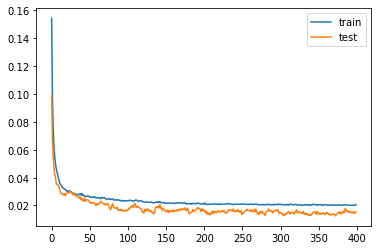

In [38]:
history = model.fit(train_X, train_y, epochs=400, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [39]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_temps*n_features))

selected_columns = [i for i in range(test_X.shape[1]) if i in [12, 13, 14]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, selected_columns2]

test_y = test_y.reshape(len(test_y), test_y.shape[1])
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())

          0      1      2           3           4          5      6       7   \
0  20.875999  0.494  1.478  673.091980  438.166992  47.861004  0.314  12.733   
1  20.877001  0.174  1.479  669.117004  437.809021  47.721004  0.128  12.730   
2  20.877001  0.389  1.478  663.067993  437.946014  47.740005  0.289  12.728   
3  20.879000  0.780  1.478  661.744019  438.044983  47.889004  0.502  12.729   
4  20.878000  0.492  1.478  663.919983  436.010010  47.858002  0.136  12.725   

            8       9          10     11  
0  1169.959961  15.370  52.881001  0.491  
1  1145.729980  15.375  52.095001  0.174  
2  1137.619995  15.366  52.841000  0.389  
3  1132.069946  15.388  52.228001  0.558  
4  1165.359985  15.355  52.105000  0.172  


In [ ]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_temps*n_features))

selected_columns = [i for i in range(test_X.shape[1]) if i in [12, 13, 14]]

inv_yhat = np.concatenate((yhat, test_X[:, selected_columns]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:, selected_columns2]

test_y = test_y.reshape(len(test_y), test_y.shape[1])
inv_y = np.concatenate((test_y, test_X[:, selected_columns]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:-3]
inv_y_df = pd.DataFrame(inv_y)
print(inv_y_df.head())

          0      1      2           3           4          5      6       7   \
0  20.875999  0.494  1.478  673.091980  438.166992  47.861004  0.314  12.733   
1  20.877001  0.174  1.479  669.117004  437.809021  47.721004  0.128  12.730   
2  20.877001  0.389  1.478  663.067993  437.946014  47.740005  0.289  12.728   
3  20.879000  0.780  1.478  661.744019  438.044983  47.889004  0.502  12.729   
4  20.878000  0.492  1.478  663.919983  436.010010  47.858002  0.136  12.725   

            8       9          10     11  
0  1169.959961  15.370  52.881001  0.491  
1  1145.729980  15.375  52.095001  0.174  
2  1137.619995  15.366  52.841000  0.389  
3  1132.069946  15.388  52.228001  0.558  
4  1165.359985  15.355  52.105000  0.172  


In [40]:
col_index = 8
col_values = inv_y_df.iloc[:, col_index]

date_indices = filtered_rows.index + train_X.shape[0] + 1
datepic = data.iloc[date_indices, col_index]
for index, value in filtered_rows.items():
    print(f"nb de ligne: {index}, valeur: {value}, dates: {datepic}\n")

nb de ligne: 247, valeur: 12475.2998046875, dates: date
2023-07-06 08:39:58    12475.30
2023-07-06 08:41:59    22527.60
2023-07-06 08:44:01    19906.70
2023-07-06 08:46:02    16101.50
2023-07-06 08:48:03    14818.90
                         ...   
2023-07-08 18:17:36    12805.50
2023-07-08 18:19:36     8968.61
2023-07-08 19:47:53     9784.25
2023-07-08 21:42:09    12539.60
2023-07-08 21:44:09     9607.30
Name: tvoc, Length: 95, dtype: float64

nb de ligne: 248, valeur: 22527.599609375, dates: date
2023-07-06 08:39:58    12475.30
2023-07-06 08:41:59    22527.60
2023-07-06 08:44:01    19906.70
2023-07-06 08:46:02    16101.50
2023-07-06 08:48:03    14818.90
                         ...   
2023-07-08 18:17:36    12805.50
2023-07-08 18:19:36     8968.61
2023-07-08 19:47:53     9784.25
2023-07-08 21:42:09    12539.60
2023-07-08 21:44:09     9607.30
Name: tvoc, Length: 95, dtype: float64

nb de ligne: 249, valeur: 19906.69921875, dates: date
2023-07-06 08:39:58    12475.30
2023-07-06 08:41:59

In [41]:
danger_limits = {
    'pm10': 101,
    'co': 201,
    'co2': 1001,
    'so2': 81,
    'no2': 81,
    'tvoc': 500,
    'o3': 100,
    'pm2_5': 61,
}

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


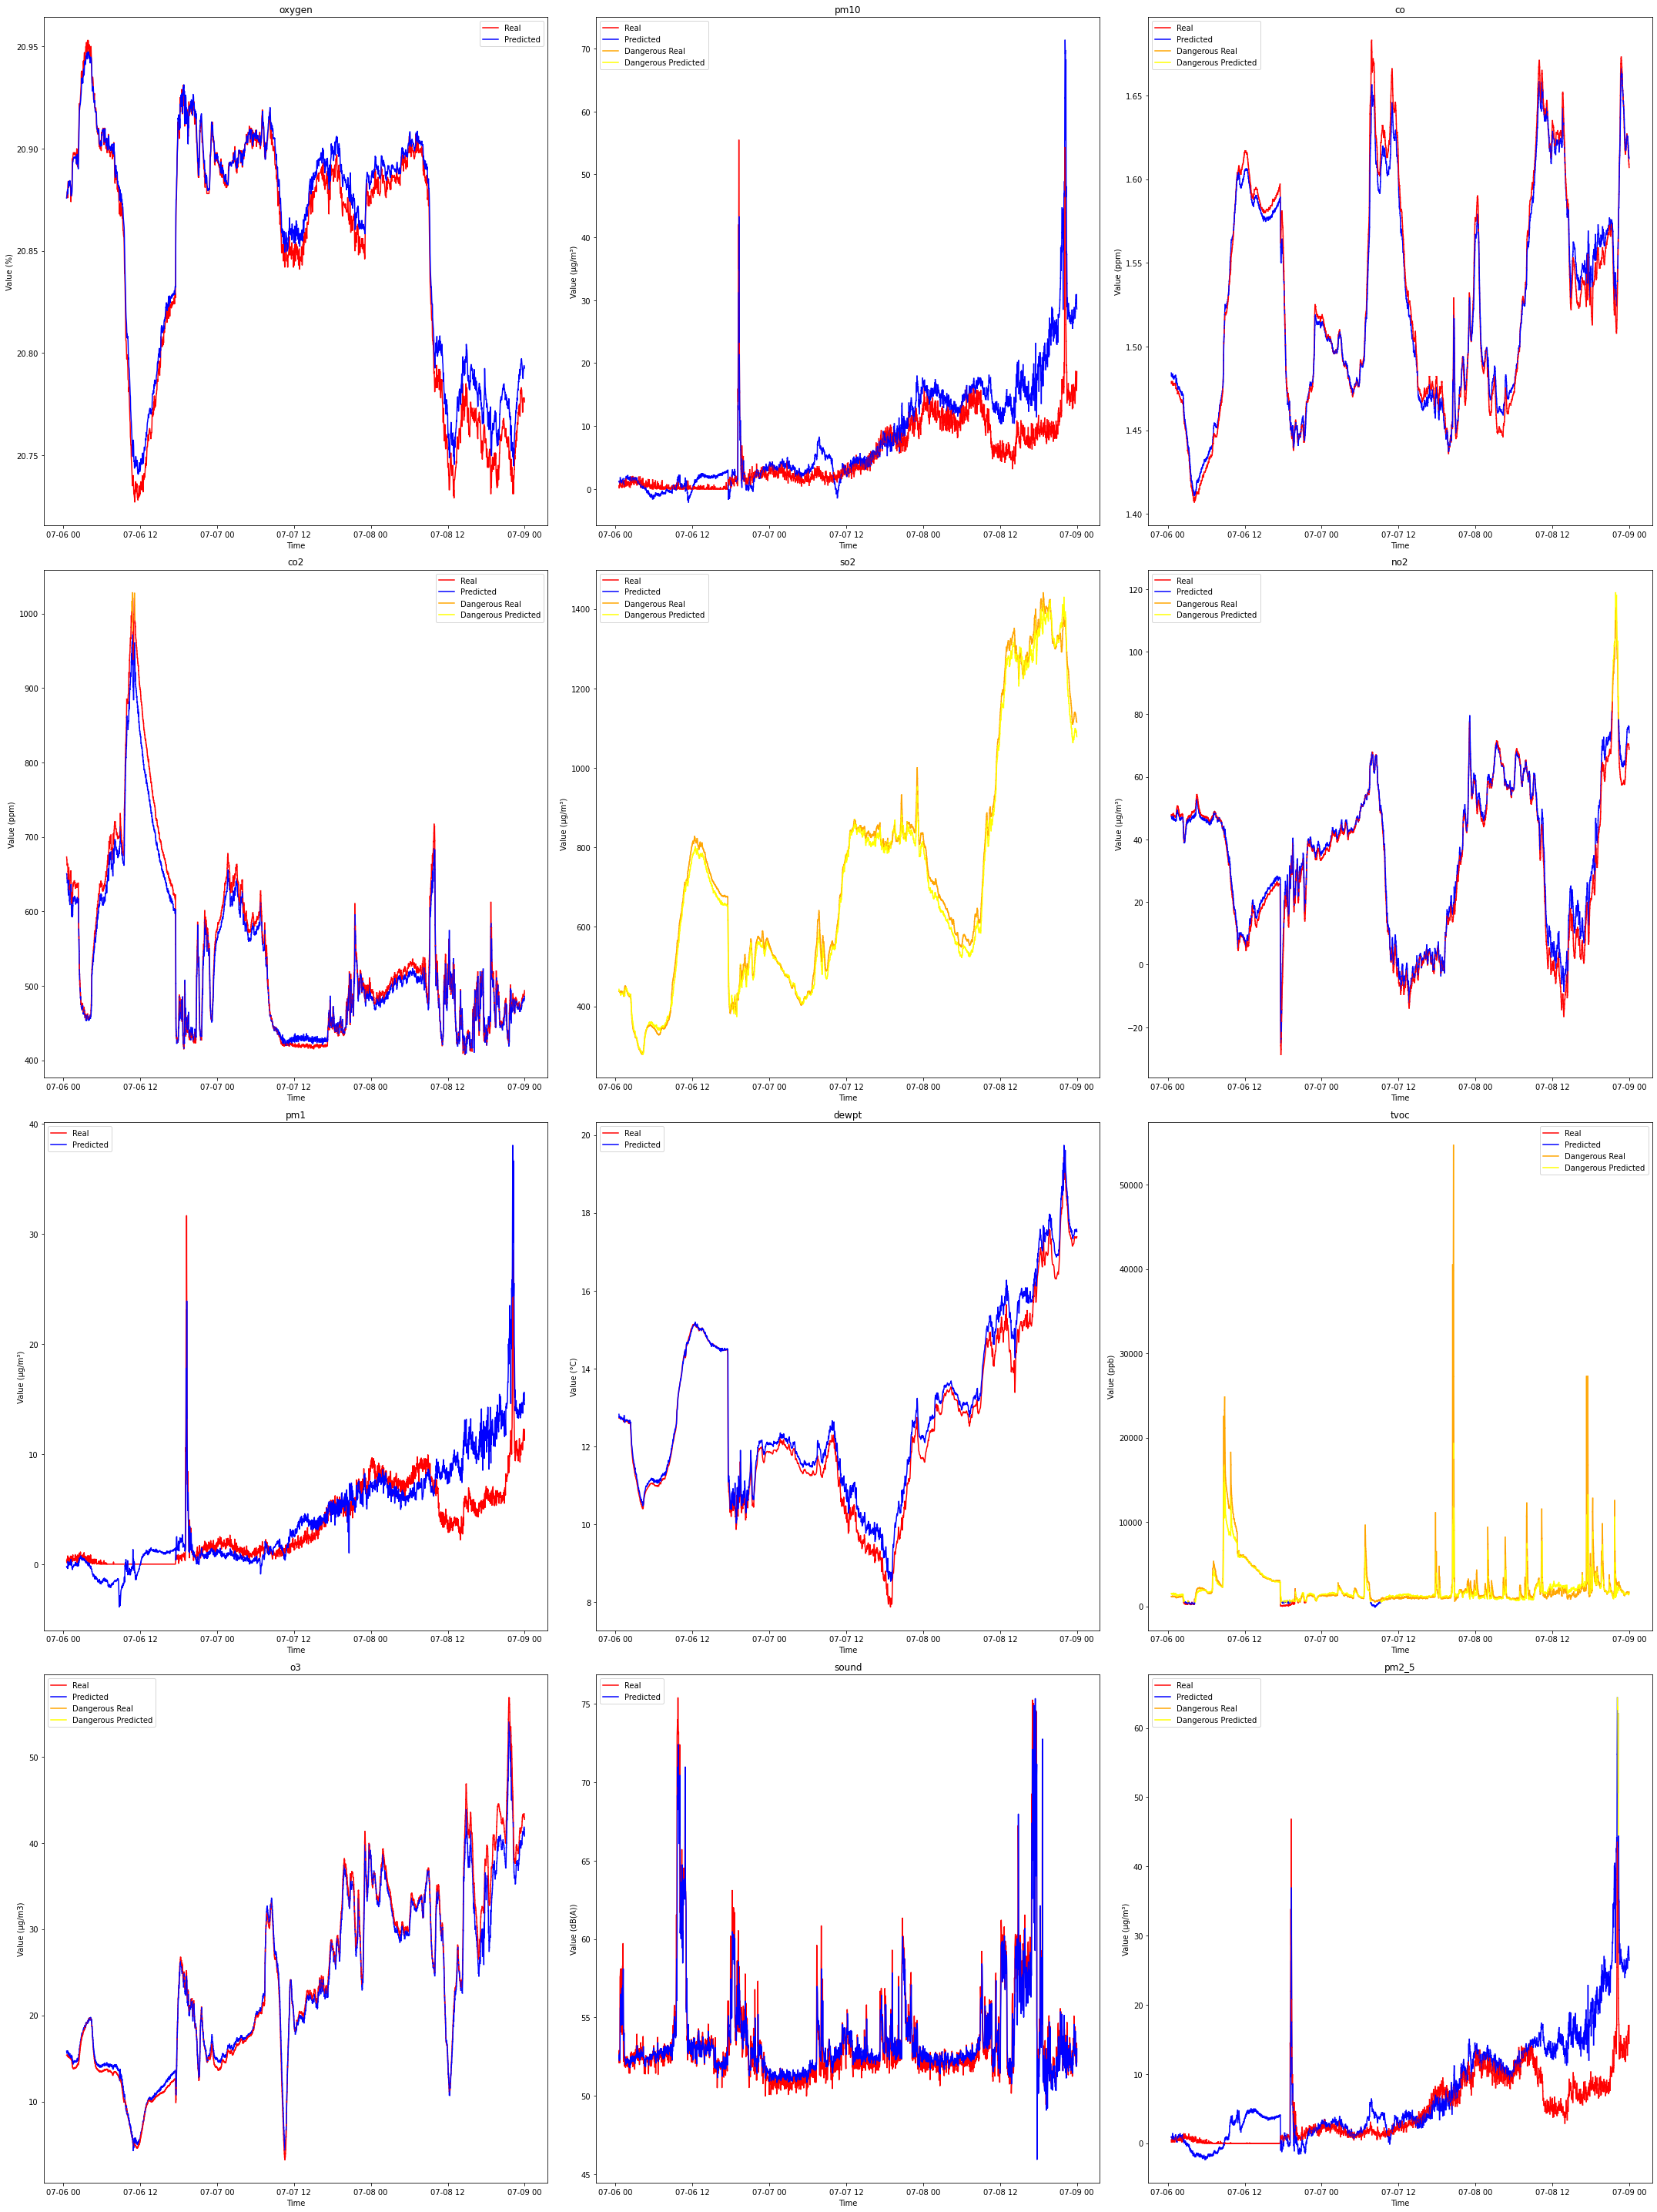

In [42]:
dates = dates[-test_y.shape[0]:]
fig, axs = plt.subplots(4, 3, figsize=(30, 40))
feature_indices = {
    'oxygen': 0, 'pm10': 1, 'co': 2, 'co2': 3, 'so2': 4,
    'no2': 5, 'pm1': 6, 'dewpt': 7, 'tvoc': 8, 'o3' : 9, 'sound': 10, 'pm2_5': 11
}

feature_units = {
    'oxygen': '%', 'pm10': 'µg/m³', 'co': 'ppm', 'co2': 'ppm',
    'so2': 'µg/m³', 'no2': 'µg/m³', 'pm1': 'µg/m³',
    'dewpt': '°C', 'tvoc': 'ppb', 'o3': 'µg/m3', 'sound': 'dB(A)', 'pm2_5': 'µg/m³'
}

for i, (feature, index) in enumerate(feature_indices.items()):
    row = i // 3
    col = i % 3

    real_values = inv_y[:, index]
    predicted_values = inv_yhat[:, index]

    axs[row, col].set_title(feature)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')

    if feature in danger_limits:
        if isinstance(danger_limits[feature], tuple):
            lower, upper = danger_limits[feature]
            real_colors = ['orange' if (x < lower or x > upper) else 'red' for x in real_values]
            pred_colors = ['yellow' if (x < lower or x > upper) else 'blue' for x in predicted_values]
        else:
            limit = danger_limits[feature]
            real_colors = ['orange' if x > limit else 'red' for x in real_values]
            pred_colors = ['yellow' if x > limit else 'blue' for x in predicted_values]

        for j in range(len(dates) - 1):
            axs[row, col].plot(dates[j:j+2], real_values[j:j+2], color=real_colors[j])
            axs[row, col].plot(dates[j:j+2], predicted_values[j:j+2], color=pred_colors[j])
    else:
        axs[row, col].plot(dates, real_values, color='red', label='Real')
        axs[row, col].plot(dates, predicted_values, color='blue', label='Predicted')

    axs[row, col].legend()

for ax in axs.flat:
    handles, labels = ax.get_legend_handles_labels()
    if not labels:
        ax.plot([], [], color='red', label='Real')
        ax.plot([], [], color='blue', label='Predicted')
        ax.plot([], [], color='orange', label='Dangerous Real')
        ax.plot([], [], color='yellow', label='Dangerous Predicted')
    ax.legend()

plt.tight_layout()
plt.show()
# for i, (feature, index) in enumerate(feature_indices.items()):
#     row = i // 3
#     col = i % 3

#     axs[row, col].plot(dates,inv_y[:, index], color='red', label='Real')
#     axs[row, col].plot(dates,inv_yhat[:, index], color='blue', label='Predicted')
#     axs[row, col].set_title(feature)
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel(f'Value ({feature_units[feature]})')
#     axs[row, col].legend()

# plt.tight_layout()
# plt.show()

L'ensemble de tests commence par des données de comptage à la ligne 9393

In [43]:
print(inv_y.shape, inv_yhat.shape)

(2133, 12) (2133, 15)


In [44]:
selected_columns2 = [i for i in range(inv_y.shape[1]) if i not in [12, 13, 14]]
inv_yhat = inv_yhat[:, selected_columns2]
inv_y = inv_y[:, selected_columns2]

In [45]:
feature_names = ['oxygen', 'pm10', 'co', 'co2', 'so2', 'no2', 'pm1', 'dewpt', 'tvoc', 'o3', 'sound', 'pm2_5']

for i, feature in enumerate(feature_names):
    rmse = sqrt(mean_squared_error(inv_y[:, i], inv_yhat[:, i]))
    # mape = np.mean(np.abs((inv_y[:, i] - inv_yhat[:, i])/inv_y[:, i]))*100
    print(f'Test RMSE for {feature}: {rmse:.3f}')
    # print(f'Rest MAPE for {feature}: {mape:.3f}%')

Test RMSE for oxygen: 0.010
Test RMSE for pm10: 5.705
Test RMSE for co: 0.008
Test RMSE for co2: 18.995
Test RMSE for so2: 22.880
Test RMSE for no2: 3.385
Test RMSE for pm1: 2.892
Test RMSE for dewpt: 0.397
Test RMSE for tvoc: 1944.492
Test RMSE for o3: 1.321
Test RMSE for sound: 1.499
Test RMSE for pm2_5: 5.754


In [46]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

inv_yhat_PM25_values = inv_yhat[:, 11]
inv_y_PM25_values = inv_y[:, 11]

inv_yhat_PM25 = np.array([get_PM25_subindex(x) for x in inv_yhat_PM25_values]).astype(float)
inv_y_PM25 = np.array([get_PM25_subindex(x) for x in inv_y_PM25_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM25.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM25.reshape(-1, 1)))

In [47]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

inv_yhat_PM10_values = inv_yhat[:, 1]
inv_y_PM10_values = inv_y[:, 1]

inv_yhat_PM10 = np.array([get_PM10_subindex(x) for x in inv_yhat_PM10_values]).astype(float)
inv_y_PM10 = np.array([get_PM10_subindex(x) for x in inv_y_PM10_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_PM10.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_PM10.reshape(-1, 1)))

In [48]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

inv_yhat_SO2_values = inv_yhat[:, 4]
inv_y_SO2_values = inv_y[:, 4]

inv_yhat_SO2= np.array([get_SO2_subindex(x) for x in inv_yhat_SO2_values]).astype(float)
inv_y_SO2 = np.array([get_SO2_subindex(x) for x in inv_y_SO2_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_SO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_SO2.reshape(-1, 1)))

In [49]:
## NO2 Sub-Index calculation
def ugm3_to_ppb(no2_ugm3):
    MW_NO2 = 46.0055  # g/mol
    standard_volume = 24.45  # L/mol
    return (no2_ugm3 * standard_volume) / MW_NO2

def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

inv_yhat_NO2_values = inv_yhat[:, 5]
inv_y_NO2_values = inv_y[:, 5]

inv_yhat_NO2= np.array([get_NO2_subindex(x) for x in ugm3_to_ppb(inv_yhat_NO2_values)]).astype(float)
inv_y_NO2 = np.array([get_NO2_subindex(x) for x in ugm3_to_ppb(inv_yhat_NO2_values)]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_NO2.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_NO2.reshape(-1, 1)))

In [50]:
def ppm_to_mgm3(co_ppm):
    MW_CO = 28.01  # g/mol
    standard_volume = 24.45  # L/mol
    return co_ppm * MW_CO / standard_volume
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

inv_yhat_CO_values = inv_yhat[:, 2]
inv_y_CO_values = inv_y[:, 2]

inv_yhat_CO= np.array([get_CO_subindex(x) for x in ppm_to_mgm3(inv_yhat_CO_values)]).astype(float)
inv_y_CO = np.array([get_CO_subindex(x) for x in ppm_to_mgm3(inv_yhat_CO_values)]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_CO.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_CO.reshape(-1, 1)))

In [51]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

inv_yhat_O3_values = inv_yhat[:, 9]
inv_y_O3_values = inv_y[:, 9]

inv_yhat_O3= np.array([get_O3_subindex(x) for x in inv_yhat_O3_values]).astype(float)
inv_y_O3 = np.array([get_O3_subindex(x) for x in inv_y_O3_values]).astype(float)

inv_yhat = np.hstack((inv_yhat, inv_yhat_O3.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_O3.reshape(-1, 1)))

In [52]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

PM25_SubIndex_col = 12
PM10_SubIndex_col = 13
SO2_SubIndex_col = 14
NO2_SubIndex_col = 15
CO_SubIndex_col = 16
O3_SubIndex_col = 17

inv_yhat_Checks = ((inv_yhat[:, PM25_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, PM10_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, SO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, NO2_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, CO_SubIndex_col] > 0).astype(int) +
                   (inv_yhat[:, O3_SubIndex_col] > 0).astype(int))

inv_y_Checks = ((inv_y[:, PM25_SubIndex_col] > 0).astype(int) +
                (inv_y[:, PM10_SubIndex_col] > 0).astype(int) +
                (inv_y[:, SO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, NO2_SubIndex_col] > 0).astype(int) +
                (inv_y[:, CO_SubIndex_col] > 0).astype(int) +
                (inv_y[:, O3_SubIndex_col] > 0).astype(int))


inv_yhat_AQI_calculated = np.max(inv_yhat[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)
inv_y_AQI_calculated = np.max(inv_y[:, [PM25_SubIndex_col, PM10_SubIndex_col, SO2_SubIndex_col, NO2_SubIndex_col, CO_SubIndex_col, O3_SubIndex_col]], axis=1)

inv_yhat_AQI_calculated[(inv_yhat[:, PM25_SubIndex_col] + inv_yhat[:, PM10_SubIndex_col] <= 0) | (inv_yhat_Checks < 3)] = np.NaN
inv_y_AQI_calculated[(inv_y[:, PM25_SubIndex_col] + inv_y[:, PM10_SubIndex_col] <= 0) | (inv_y_Checks < 3)] = np.NaN

inv_yhat_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_yhat_AQI_calculated])
inv_y_AQI_bucket_calculated = np.array([get_AQI_bucket(x) for x in inv_y_AQI_calculated])

inv_yhat = np.hstack((inv_yhat, inv_yhat_AQI_calculated.reshape(-1, 1), inv_yhat_Checks.reshape(-1, 1)))
inv_y = np.hstack((inv_y, inv_y_AQI_calculated.reshape(-1, 1), inv_y_Checks.reshape(-1, 1)))

inv_yhat_df = pd.DataFrame(inv_yhat, columns=[f'col{i}' for i in range(inv_yhat.shape[1] - 2)] + ['AQI_calculated', 'Checks'])
inv_y_df = pd.DataFrame(inv_y, columns=[f'col{i}' for i in range(inv_y.shape[1] - 2)] + ['AQI_calculated', 'Checks'])

inv_yhat_df['AQI_bucket_calculated'] = inv_yhat_AQI_bucket_calculated
inv_y_df['AQI_bucket_calculated'] = inv_y_AQI_bucket_calculated

print(inv_yhat_df.head(5))
print(inv_y_df.head(5))

        col0      col1      col2        col3        col4       col5      col6  \
0  20.875813  1.203134  1.484211  650.475220  442.963165  47.421913 -0.216024   
1  20.876959  1.138225  1.482478  649.822815  438.767029  47.262115 -0.306147   
2  20.877876  1.120317  1.482986  644.594299  439.026184  46.670799 -0.305979   
3  20.878624  1.127835  1.482663  638.889648  438.143890  47.119267 -0.251016   
4  20.879930  1.236818  1.482057  638.854492  437.096893  47.221817 -0.236616   

        col7         col8       col9  ...     col11     col12     col13  \
0  12.828666  1505.427124  15.836322  ...  0.943571  1.572618  1.203134   
1  12.744170  1498.964233  15.636425  ...  0.824133  1.373555  1.138225   
2  12.764404  1470.586914  15.832393  ...  0.796600  1.327666  1.120317   
3  12.753343  1449.188965  15.865550  ...  0.783500  1.305834  1.127835   
4  12.765009  1461.715820  15.847628  ...  0.855055  1.425092  1.236818   

        col14      col15      col16      col17  AQI_calculated

In [53]:
# print("inv_y:\n", inv_y)
# print("inv_yhat:\n", inv_yhat)

In [54]:
accuracy_normalized = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=True)
print("Accuracy: " + str(accuracy_normalized))

Accuracy: 0.7782466010314112


In [55]:
num_correct = accuracy_score(inv_y[:,-1], inv_yhat[:,-1], normalize=False)
print(num_correct) 

1660
